In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import cv2

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
img = cv2.imread("img/64_64_4096pixel.bmp", 0)
h,w = img.shape
N = h*w

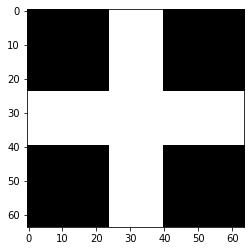

In [3]:
plt.imshow(img, cmap="gray")
plt.show()

In [4]:
M = N
W = np.random.rand(M, N)
W = np.where(W>0.5, 1, 0)

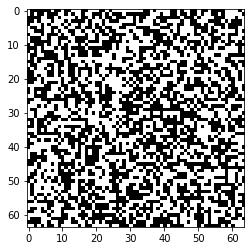

In [5]:
plt.imshow(W[0].reshape(h,w), cmap="gray")
plt.show()

In [6]:
Y = np.dot(W, img.reshape(N,1))

In [7]:
def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [8]:
def compressed_sensing(Y, W, alpha):
    #ψ作製
    #print(np.identity(h).shape)
    #print(spfft.idct(np.identity(h)).shape)
    psi = np.kron(
        spfft.idct(np.identity(h).astype("float64"), norm='ortho', axis=0),
        spfft.idct(np.identity(w).astype("float64"), norm='ortho', axis=0)
        ).astype("float64")
    #print(psi.shape)
    # A = Wψ  (M.N) × (N,N) = (M,N)
    A = np.dot(W, psi).astype("float64")
    #print(A.shape)
    # Lasso再構成
    #alpha　ノイズが小さいときは小さく，大きいときは大きく
    lasso = Lasso(alpha=alpha)
    lasso.fit(A, Y)
    
    #lasso.coef_でlassoの係数を取得（再構成に相当）
    Xat = np.array(lasso.coef_).reshape(h, w).T 
    #print(lasso.coef_.shape)
    
    #スパース領域(画像を離散コサイン変換した領域)の再構成なので実空間領域に変換
    cs_rec = idct2(Xat)
    return cs_rec,Xat

In [9]:
cs_rec,Xat = compressed_sensing(Y[:], W[:], alpha=0.1)

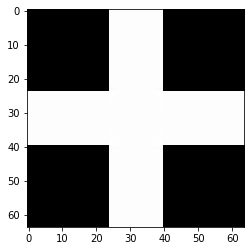

In [10]:
plt.imshow(cs_rec, cmap="gray")
plt.show()

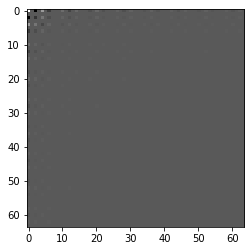

In [11]:
plt.imshow(Xat, cmap="gray")
plt.show()

In [12]:
mean_squared_error(img, cs_rec)

0.04685332009709365

In [84]:
cs_mse = []
inv_mse = []
for per in range(1,11,1):
    per *= 0.1
    num = int(N * per)
    cs_rec,Xat = compressed_sensing(Y[:num], W[:num], alpha=0.1)
    inv_W = np.linalg.pinv(W[:num])
    inv_rec = np.dot(inv_W, Y[:num]).reshape(h,w)
    
    cs_mse.append(mean_squared_error(img, cs_rec))
    inv_mse.append(mean_squared_error(img, inv_rec))

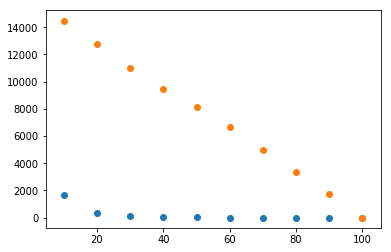

In [86]:
num_of_meas = np.arange(10,110,10)
plt.scatter(x=num_of_meas, y=cs_mse)
plt.scatter(x=num_of_meas, y=inv_mse)